In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats import proportion

from psyfun import io, atlas, spikes, plots, util
from psyfun.config import *

In [1]:
from pymer4.models import Lmer

## Data Loading & Preparation

Load the metadata for all sessions and units.

In [25]:
# Load session info
df_sessions = io.load_sessions()  # session info 

In [26]:
# Load unit info
df_units = io.load_units()
df_units['coarse_region'] = atlas.coarse_regions(df_units['region'])  # convert specific anatomical acronym to more coarse parcellation

Filter low-quality sessions

In [27]:
print(f"Total sessions: {len(df_sessions)}")

# Remove sessions missing timing information for important experimental epochs
task_epochs = ['task00_spontaneous_start', 'task01_spontaneous_start', 'task00_replay_start', 'task01_replay_start']
df_sessions = df_sessions.dropna(subset=task_epochs)


# JA: drop massive outlier from my recordings, this recording should probably be removed from the dataset altogether
# Recording from ZFM-08457 on 2025-03-20, eid: 'e31bff07-d66c-4a03-894d-f71030161ead'
# Notes from recording: No spikes!!! -> SAC!

# DC: I wouldn't be so quick to drop, it has many good units and reasonable firing rate distribution
# eid = 'e31bff07-d66c-4a03-894d-f71030161ead'
# df_session = df_units.query('eid == @eid')
# df_goodunits = df_session.query('ks2_label == "good"')
# print(f"Total units: {len(df_session)}")
# print(f"Good units: {len(df_goodunits)}")
# plt.hist(df_goodunits['firing_rate'])

# To drop the session, run:
# df_sessions = df_sessions[df_sessions['eid'] != 'e31bff07-d66c-4a03-894d-f71030161ead']
# DC: Pretty sure it's dropped anyways as there is no data for the second task

print(f"Remaining sessions: {len(df_sessions)}")

Total sessions: 40
Remaining sessions: 35


Filter low-quality units

In [28]:
# Get eids for remaining sessions
eids = df_sessions['eid'].tolist()
df_units = df_units.query('eid in @eids')
print(f"Total units: {len(df_units)}")

# Some useful filters:
unit_filter = 'ks2_label == "good"'  # kilosort label for well-isolated units, as opposed to multi-unit activity (mua)
# unit_filter = 'label == 1.0'  # more conservative IBL quality criterion
# Additional filters can be constructed using any column of the unit metadata
# print(df_units.columns)

# Remove low-quality units
df_units = df_units.query(unit_filter)
print(f"Remaining units: {len(df_units)}")

Total units: 79454
Remaining units: 14886


Load spike times for remaining good units

In [29]:
# Load spike times
df_spiketimes = io.load_spikes(df_units['uuid'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:04<00:00, 3557.76it/s]


Merge spike times, unit info, and session info dataframes

In [30]:
# Join spike times with unit info
df_spikes = df_units.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessions, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns after merge
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]

### Mean firing rate

In [31]:
# Collect spike counts for each task epoch and get mean rate
epochs = ['task00_spontaneous', 'task01_spontaneous', 'task00_rfm', 'task01_rfm', 'task00_replay', 'task01_replay']

dt = 1  # 1s bins
for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())  # compute mean
    df_spikes[f'{epoch}_lograte'] = np.log10(df_spikes[f'{epoch}_rate'])  # log-transform
# Note: log-transform is applied to normalize mean rate distributions (Buzsáki & Mizuseki, 2014, Nat Rev Neuro)

Getting spike counts for: task00_spontaneous


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 5493.91it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task01_spontaneous


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 5943.39it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task00_rfm


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 6478.17it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task01_rfm


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 6446.22it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task00_replay


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 6545.64it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task01_replay


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 6616.94it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


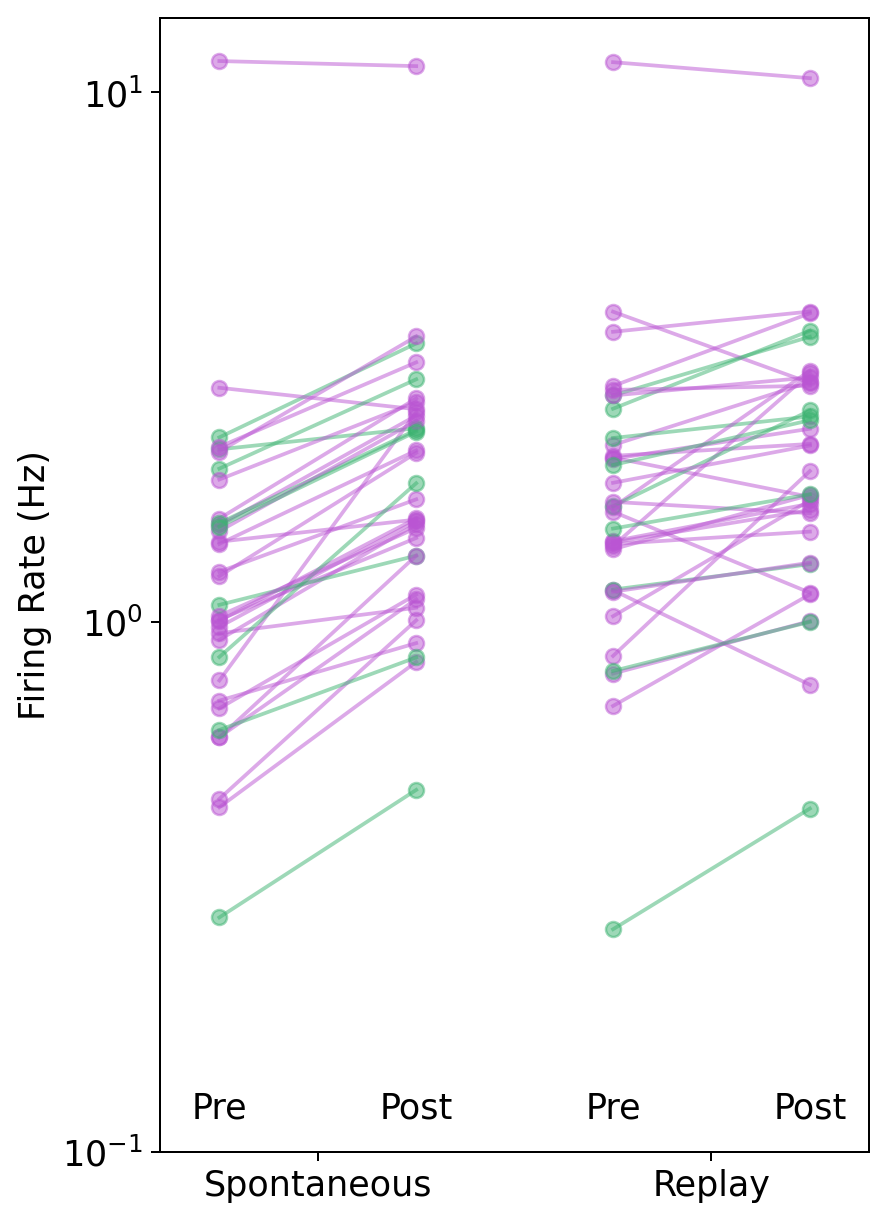

In [11]:
# Plot mean firing rate changes per session (eid)
tasks = ['task00', 'task01']  # here, we split epoch into two separable factors: 1) the task period, pre (00) or post (01) treatment
# epochs = ['spontaneous', 'rfm', 'replay']  # and 2) the experimental epoch
epochs = ['spontaneous', 'replay',]
metric = 'lograte'
xoffset = 0.25
fig, ax = plt.subplots()
for idx, session in df_spikes.groupby('eid'):
    pos = 0
    for epoch in epochs:
        x = pos + np.array([-xoffset, xoffset])
        y = np.array([np.nanmedian(session[f'{task}_{epoch}_{metric}'].replace(-np.inf, np.nan)) for task in tasks])
        color = CONTROLCOLOR if session['control_recording'].unique()[0] else LSDCOLOR
        ax.plot(x, y, color=color, marker='o', alpha=0.5)
        pos += 1
ax.set_xticks(range(len(epochs)))
ax.set_xticklabels([e.capitalize() for e in epochs])
for xpos, label in zip([-1, 1], ['Pre', 'Post']):
    ax.text(0 + xpos * xoffset, -0.95, label, va='bottom', ha='center', fontsize=plots.LABELFONTSIZE)
    ax.text(1 + xpos * xoffset, -0.95, label, va='bottom', ha='center', fontsize=plots.LABELFONTSIZE)
ax.set_xlim([-0.4, 1.4])
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels(['$10^{%d}$' % tick for tick in [-1, 0, 1]])
ax.set_ylabel('Firing Rate (Hz)')

plots.set_plotsize(w=10, h=16, ax=ax)
fig.savefig('figures/lograte.svg')

## Multi-level statistical analysis
- the data has a two-level "cross-classified" nested hierarchical structure:
  - repeated observations are drawn from each neuron across the epoch and task variable
  - different brain regions (sets of neurons) are targeted in different sessions from the same mouse
  - pairs of experimental and control recordings target the same brain regions (across hemispheres) within the same mouse
  - therefore some factors are repeated across individual experimental units, others are across different subsets of experimental units that can be grouped
- TODO: assess intra-class correlations for different grouping levels (neurons, insertion trajectories, mice) to see which is strongest

In [12]:
# Convert dataframe to long format
df_rates = df_spikes.melt(
    id_vars=['subject', 'eid', 'uuid', 'control_recording', 'trajectory_label'],
    value_vars=[col for col in df_spikes.columns if col.endswith('_lograte')],
    var_name='epoch',
    value_name='lograte'
).replace(-np.inf, np.nan).dropna()
df_rates['task'] = df_rates['epoch'].apply(lambda x: x.split('_')[0])
df_rates['epoch'] = df_rates['epoch'].apply(lambda x: x.split('_')[1])
df_rates = df_rates[df_rates['epoch'].apply(lambda x: x in epochs)]  # Take only epochs of interest

# Build composite variable for grouping
df_rates['subject_trajectory'] = df_rates.apply(lambda x: '_'.join([x['subject'], x['trajectory_label']]), axis='columns')

In [14]:
# Fit model with joint effects and random slopes/intercepts for each eid
model = smf.mixedlm('lograte ~ C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + ' + # main effects 
                    'C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording)',  # interactions
                    data=df_rates,
                    # groups=df_rates['subject_trajectory'],  # Group by mouse & insertion trajectory
                    groups=df_rates['subject'],  # Group by mouse
                    # groups=df_rates['trajectory_label'],  # Group by trajectory
                    # Random slopes for all predictors (omit if only random intercepts are allowed)
                    re_formula='~C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous"))'  # main effects (only within-subject factors)
                    # + C(task, Treatment("task00"))*C(control_recording)  # add this when we have more than one subject
                   )
result = model.fit()
print(result.summary())

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                                                                 Mixed Linear Model Regression Results
Model:                                                             MixedLM                                                Dependent Variable:                                                lograte    
No. Observations:                                                  57512                                                  Method:                                                            REML       
No. Groups:                                                        16                                                     Scale:                                                             0.7612     
Min. group size:                                                   767                                                    Log-Likelihood:                                                    -73851.0687
Max. group size:                                                   6840      

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [16]:
# Fit separate models for each experimental epoch
for epoch in epochs:
    df_epoch = df_rates.query('epoch == @epoch')
    # Specify model with joint effects and random slopes/intercepts for each eid
    model = smf.mixedlm('lograte ~ C(task, Treatment("task00")) + C(control_recording) + C(task, Treatment("task00"))*C(control_recording)', 
                        data=df_epoch,
                        groups=df_epoch['subject_trajectory'],  # Group by mouse & insertion trajectory
                        re_formula='~C(task, Treatment("task00"))')  # Random slopes for all predictors
    # Fit & summarize
    result = model.fit()
    print(f"Epoch: {epoch}")
    print(result.summary())

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Epoch: spontaneous
                                    Mixed Linear Model Regression Results
Model:                               MixedLM                  Dependent Variable:                  lograte    
No. Observations:                    28575                    Method:                              REML       
No. Groups:                          19                       Scale:                               0.7563     
Min. group size:                     377                      Log-Likelihood:                      -36609.2474
Max. group size:                     2727                     Converged:                           Yes        
Mean group size:                     1503.9                                                                   
--------------------------------------------------------------------------------------------------------------
                                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Firing rate modulation index (MI)

Compute MI for pairs of epochs de-novo.

In [36]:
# Define pairs of epochs over which to compare firing rates
epoch_pairs = {
    'spontaneous': ['task00_spontaneous', 'task01_spontaneous'],
    'replay': ['task00_replay', 'task01_replay']
}

# Get firing rate MI for all pairs of epochs (Note: this takes some time, so best to load the dataframe if already computed)
# MIs = df_spikes.progress_apply(spikes._apply_modulation_index, epoch_pairs=epoch_pairs, axis='columns')
# df_MI = pd.DataFrame(MIs.to_list(), index=df_spikes.index)
# FIXME: do we need to fix the dtype of the MIs? ...It shouldn't be inconsistent
# df_MI = pd.DataFrame(MIs.to_list(), index=df_spikes.index).map(lambda x: float(x) if isinstance(x, np.ndarray) else x)

In [141]:
# Add to df_spikes
df_spikes = pd.concat([df_spikes, df_MI], axis=1)

# Clean up the columns & save
# columns_to_keep = [
#     'uuid', 'eid', 'subject', 'n_probes', 'n_tasks', 'start_time', 'control_recording', 'session_n',
#     'amp_median', 'contamination', 'drift', 'label', 
#     'x', 'y', 'z', 'region', 'coarse_region',
#     'spontaneous_MI', 'spontaneous_p', 'replay_MI', 'replay_p'
# ]
# df_spikes[columns_to_keep].to_parquet('data/MIs.pqt')

Load previously computed MIs.

In [17]:
from pathlib import Path
df_MI = pd.read_parquet(PROJECT_ROOT / Path('data/MIs.pqt'))
df_spikes = pd.concat([df_spikes, df_MI], axis=1)

Plot MI distributions for each condition.

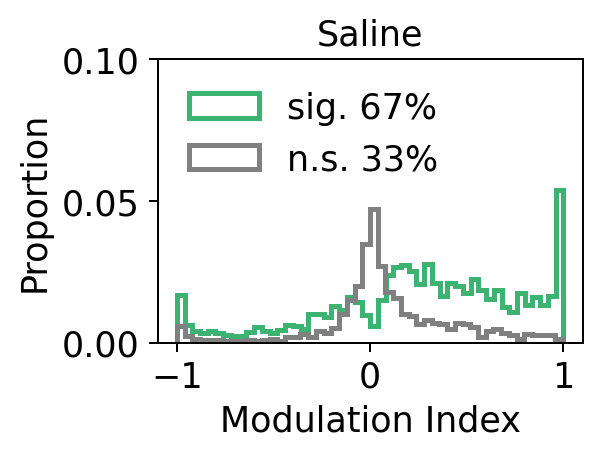

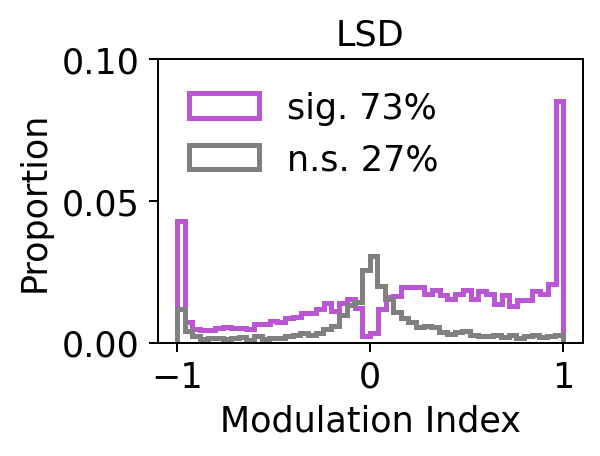

In [18]:
# Define the epoch of interest
epoch = 'spontaneous'

for control in [True, False]:
    fig, ax = plt.subplots()
    title = 'Saline' if control else 'LSD'
    ax.set_title(title)
    df_condition = df_MI.query('control_recording == @control')
    
    # queries = [
    #     f'{epoch}_p <= 0.025 or {epoch}_p >= 0.975',
    #     f'{epoch}_p > 0.025 and {epoch}_p < 0.975'
    # ]
    # Bonferroni correction for multiple comparisons
    alpha_corrected = 0.05 / len(df_condition)  # or number of tests being performed
    queries = [
        f'{epoch}_p <= {alpha_corrected/2} or {epoch}_p >= {1 - alpha_corrected/2}',
        f'{epoch}_p > {alpha_corrected/2} and {epoch}_p < {1 - alpha_corrected/2}'
    ]
    cmap = cmaps['control'] if control else cmaps['LSD']
    colors = [cmap(1.), cmap(0.)]
    
    for query, color, label in zip(queries, colors, ['sig.', 'n.s.']):
        df_sig = df_condition.query(query)
        weights = np.ones(len(df_sig)) / len(df_condition)
        # label = f'{label} ({len(df_sig)}/{len(df_condition)}, {len(df_sig)/len(df_condition)*100:.1f}%)'
        label = f'{label} {len(df_sig)/len(df_condition)*100:.0f}%'
        ax.hist(df_sig[f'{epoch}_MI'], bins=50, weights=weights, histtype='step', linewidth=2, color=color, label=label)
    
    ax.set_xticks([-1, 0, 1])
    ax.set_xlabel('Modulation Index')
    ax.set_yticks([0, 0.05, 0.1])
    ax.set_ylabel('Proportion')
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=False)
    
    plots.set_plotsize(w=6, h=4)
    fig.savefig(f'figures/MI_{title.lower()}.svg')

Anatomical distribution of MIs

In [19]:
# Get coarse anatomical parcellation
df_MI['coarse_region'] = atlas.coarse_regions(df_MI['region'])
df_MI = df_MI.query('(coarse_region != "Fiber tract") and (coarse_region != "None")')  # drop uninformative regions

Proportion of neurons with a significant MI in each region

/tmp/ipykernel_724154/2962515372.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_significant = df_condition.groupby('coarse_region').apply(lambda x: x[f'{epoch}_significant'].sum())
/tmp/ipykernel_724154/2962515372.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_significant = df_condition.groupby('coarse_region').apply(lambda x: x[f'{epoch}_significant'].sum())


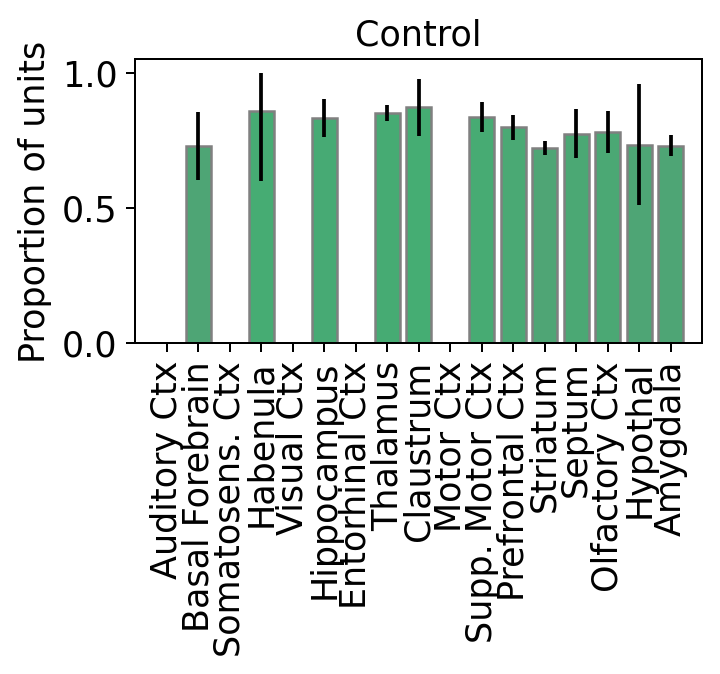

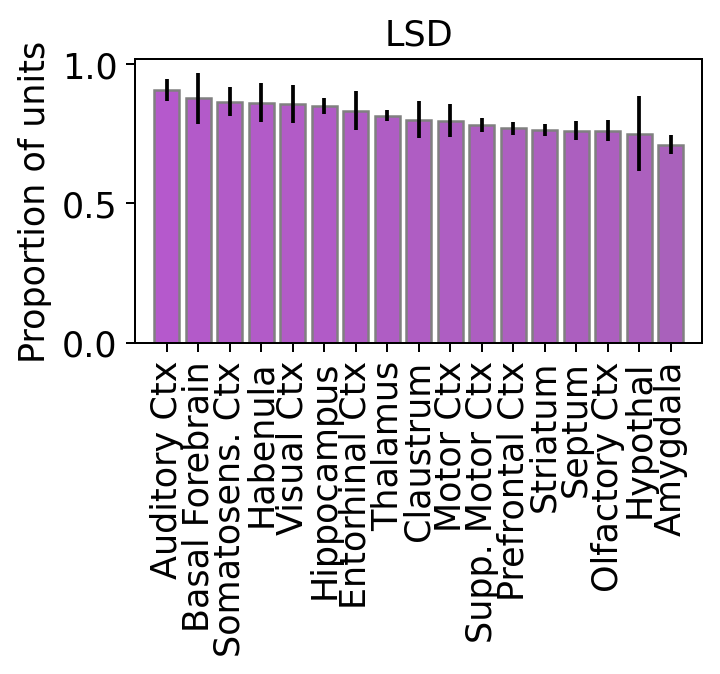

In [46]:
# Define the epoch of interest
epoch = 'spontaneous'

# Perform 2-sided significance test
df_MI[f'{epoch}_significant'] = df_MI[f'{epoch}_p'].apply(lambda x: (x <= 0.025) or (x >= 0.975))
sorted_regions = util.sort_groups(
    df_MI,  # dataframe to sort groups in
    f'{epoch}_significant',  # column with values of interest
    'coarse_region',  # grouping column
    aggfunc=np.mean,  # mean of T/F give proportion True
    reference_condition=('control_recording', False)  # region order determined by sorting LSD recording values
)

# fig, ax = plt.subplots()
for condition in [True, False]:
    # Get data for this condition
    df_condition = df_MI.query('control_recording == @condition')
    
    # Count neurons per region
    n_significant = df_condition.groupby('coarse_region').apply(lambda x: x[f'{epoch}_significant'].sum())
    n_neurons = df_condition.groupby('coarse_region').size()
    
    # Proportion of significant neurons pooled across recordings
    p_significant = (n_significant / n_neurons)
    y_neg, y_pos = proportion.proportion_confint(n_significant, n_neurons, alpha=0.05) # alpha=0.05 specifies a 95% CI
    yerr = np.vstack([p_significant - y_neg, y_pos - p_significant])

    xpos = np.array([sorted_regions[region] for region in p_significant.index])

    cmap = cmaps['control'] if condition else cmaps['LSD']
    colors = np.array([cmap(p) for p in p_significant])

    fig, ax = plt.subplots()
    ax.set_title('Control' if condition else 'LSD')
    ax.bar(xpos, p_significant, yerr=yerr, fc=colors, ec='gray')
    ax.set_xticks(np.fromiter(sorted_regions.values(), dtype=int))
    ax.set_xticklabels(sorted_regions.keys())
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlim([-1, len(sorted_regions)])
    ax.set_ylabel('Proportion of units')
    
    plots.set_plotsize(w=8, h=4)

Mean MI for each region across conditions. Statistical significance assessed with a LMM grouping by subject.

Amygdala: fitting multi-level model with 1 subjects in both conditions
Auditory Ctx: skipping, too few neurons per condition!
Basal Forebrain: fitting multi-level model with 1 subjects in both conditions
Claustrum: reverting to OLS (ANOVA), too few subjects per condition!
Entorhinal Ctx: skipping, too few neurons per condition!
Fiber tract: fitting multi-level model with 1 subjects in both conditions


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Habenula: skipping, too few neurons per condition!
Hippocampus: fitting multi-level model with 1 subjects in both conditions
Hypothal: fitting multi-level model with 1 subjects in both conditions
Motor Ctx: skipping, too few neurons per condition!
Olfactory Ctx: reverting to OLS (ANOVA), too few subjects per condition!
Prefrontal Ctx: fitting multi-level model with 1 subjects in both conditions


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:224

Septum: fitting multi-level model with 1 subjects in both conditions
Somatosens. Ctx: skipping, too few neurons per condition!
Striatum: fitting multi-level model with 1 subjects in both conditions
Supp. Motor Ctx: reverting to OLS (ANOVA), too few subjects per condition!
Thalamus: fitting multi-level model with 1 subjects in both conditions
Visual Ctx: skipping, too few neurons per condition!


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_859790/1654625697.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pvals = df.groupby('coarse_region').apply(_mixed_lm)


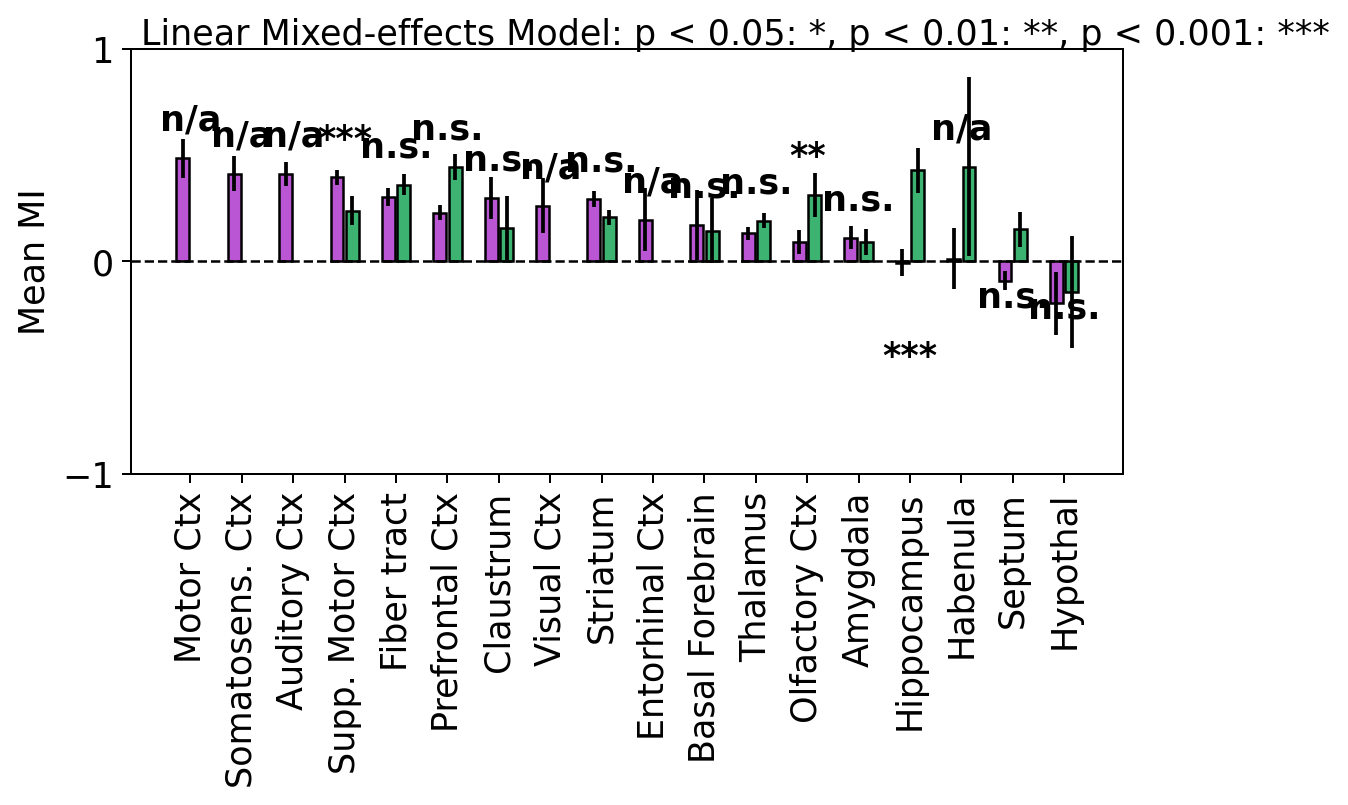

In [40]:
epoch = 'spontaneous'
fig, ax = plt.subplots()

# Prepare data: keep only significant neurons
df = df_MI.dropna(subset=[f'{epoch}_MI']).query(f'{epoch}_p < 0.025 or {epoch}_p > 0.975')

# Compute mean MI per region (all data), for sorting
region_means = df.groupby('coarse_region')[f'{epoch}_MI'].mean()
sorted_regions = region_means.sort_values(ascending=False).index.tolist()

# Compute means and errors for each group (control and LSD/experimental)
MI = df.groupby(['coarse_region', 'control_recording'])[f'{epoch}_MI'].agg(['mean', 'sem']).unstack()

def _mixed_lm(group_data, min_n_neurons=7):
    group_data.reset_index(drop=True, inplace=True)
    min_neurons_per_condition = min(sum(group_data['control_recording'] == True), sum(group_data['control_recording'] == False))
    n_subjects_both_conditions = sum(group_data.groupby('subject')['control_recording'].nunique() == 2)
    
    if min_neurons_per_condition < min_n_neurons:
        print(f"{group_data.name}: skipping, too few neurons per condition!")
        return np.nan
    elif n_subjects_both_conditions < 1:
        print(f"{group_data.name}: reverting to OLS (ANOVA), too few subjects per condition!")
        model = smf.ols(f'{epoch}_MI ~ C(control_recording)', group_data)
        result = model.fit()
    else:
        print(f"{group_data.name}: fitting multi-level model with {n_subjects_both_conditions} subjects in both conditions")
        model = smf.mixedlm(f'{epoch}_MI ~ C(control_recording)', group_data, groups=group_data["subject"], re_formula='~C(control_recording)')
        try:
            result = model.fit(method='lbfgs')
            if not result.converged:
                print(f"Model failed to converge for coarse_region {group_data.name}")
                return np.nan
        except:
            return np.nan
    return result.pvalues['C(control_recording)[T.True]']
pvals = df.groupby('coarse_region').apply(_mixed_lm)

xpos = np.arange(len(sorted_regions))
for control, offset in zip([False, True], [-0.15, 0.15]):
    means = MI['mean'].loc[sorted_regions, control].values
    err   = MI['sem'].loc[sorted_regions, control].values * 1.96
    color = CONTROLCOLOR if control else LSDCOLOR
    ax.bar(xpos + offset, means, yerr=err, width=0.25, color=color, edgecolor='k')

for i, region in enumerate(sorted_regions):
    p = pvals.loc[region]
    h_control = MI['mean'].loc[region, True]
    h_lsd   = MI['mean'].loc[region, False]
    ypos = np.nanmax([np.abs(h_lsd), np.abs(h_control)]) * np.sign(h_lsd)
    ax.text(xpos[i], ypos + (0.1 * np.sign(ypos)), plots.pval2stars(p), ha='center', va='bottom', fontsize=plots.LABELFONTSIZE, fontweight='bold', color='k')

ax.axhline(0, color='k', linewidth=1, linestyle='--')
ax.set_xticks(xpos)
ax.set_xticklabels(sorted_regions, rotation=90)
ax.set_yticks([-1, 0, 1])
ax.set_ylabel('Mean MI')

# ax.text(xpos[0] - 1, 0.01, 'Higher rate after treatment >', fontsize=plots.LABELFONTSIZE, va='bottom', ha='left', rotation=90)
# ax.text(xpos[-1] + 1, -0.01, 'Lower rate after treatment >', fontsize=plots.LABELFONTSIZE, va='top', ha='right', rotation=270)
ax.text(0.01, 1.01, 'Linear Mixed-effects Model: p < 0.05: *, p < 0.01: **, p < 0.001: ***', 
        transform=ax.transAxes, fontsize=plots.LABELFONTSIZE)

plots.set_plotsize(w=14, h=6)

Amygdala: fitting multi-level model with 1 subjects in both conditions
Auditory Ctx: skipping, too few neurons per condition!
Basal Forebrain: fitting multi-level model with 1 subjects in both conditions
Claustrum: reverting to OLS (ANOVA), too few subjects per condition!
Entorhinal Ctx: skipping, too few neurons per condition!
Hippocampus: fitting multi-level model with 1 subjects in both conditions
Hypothal: fitting multi-level model with 1 subjects in both conditions
Motor Ctx: skipping, too few neurons per condition!
Olfactory Ctx: reverting to OLS (ANOVA), too few subjects per condition!
Prefrontal Ctx: fitting multi-level model with 1 subjects in both conditions
Septum: fitting multi-level model with 1 subjects in both conditions
Somatosens. Ctx: skipping, too few neurons per condition!
Striatum: fitting multi-level model with 1 subjects in both conditions
Supp. Motor Ctx: reverting to OLS (ANOVA), too few subjects per condition!
Thalamus: fitting multi-level model with 1 subject

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at 

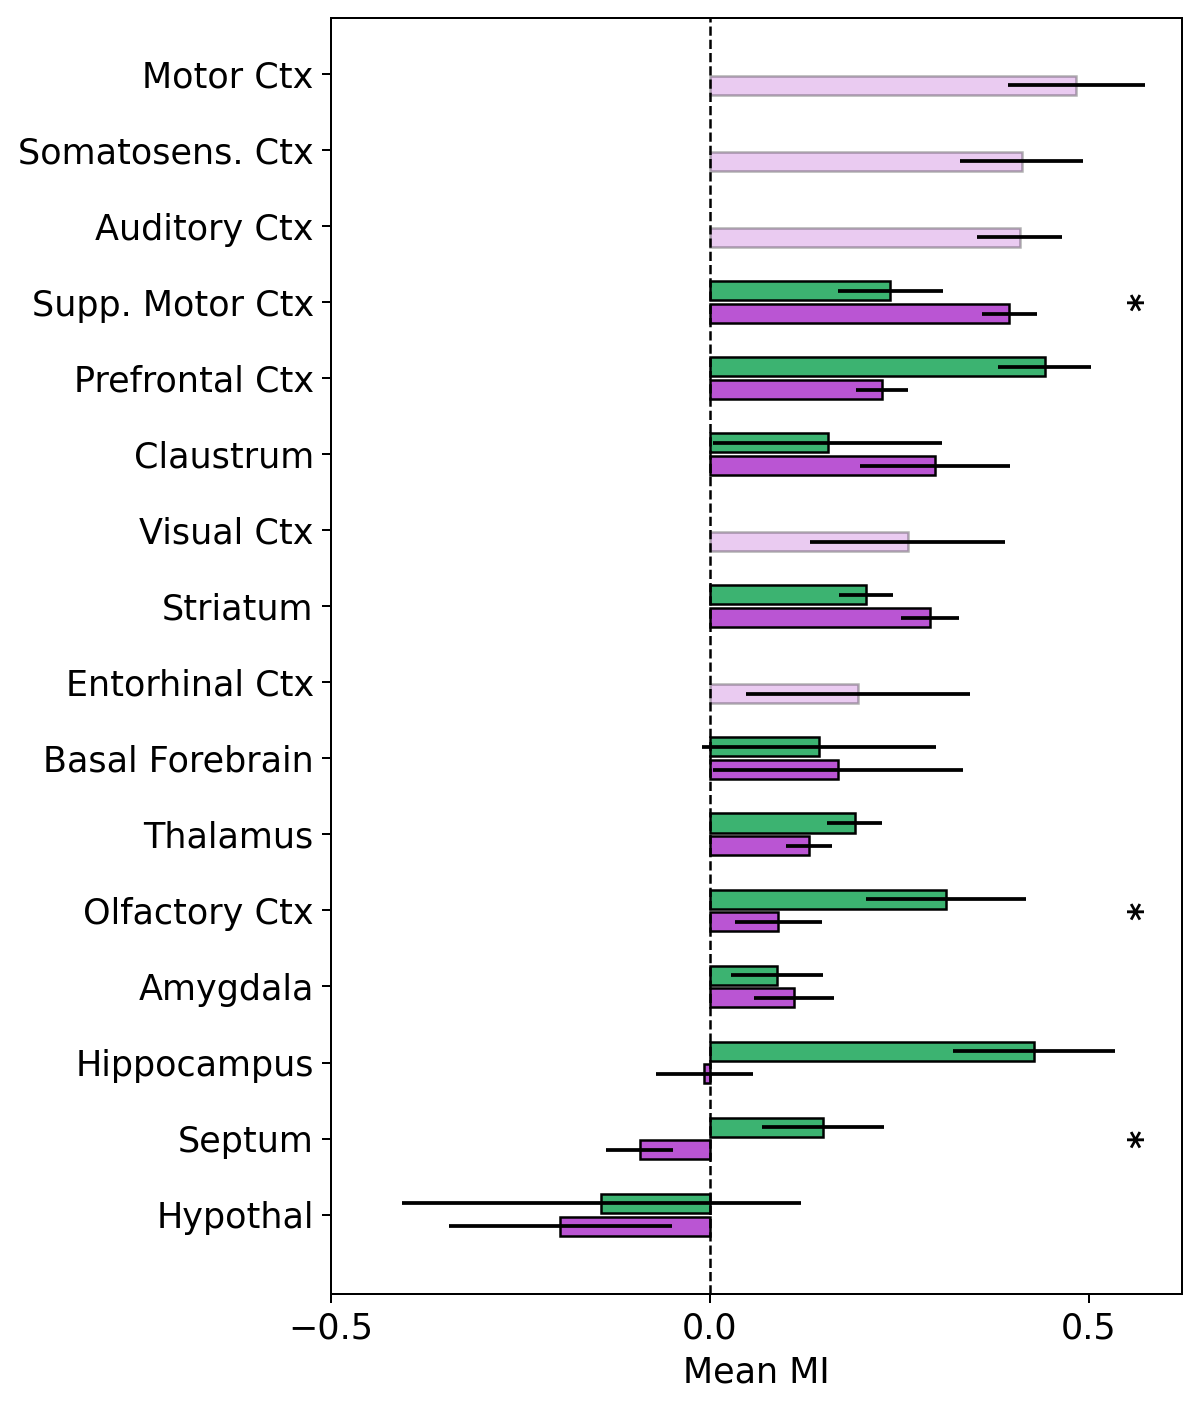

In [21]:
epoch = 'spontaneous'
fig, ax = plt.subplots()

# Prepare data: keep only significant neurons
df = df_MI.dropna(subset=[f'{epoch}_MI']).query(f'({epoch}_p < 0.025 or {epoch}_p > 0.975) and coarse_region != "Habenula"')

# Compute mean MI per region (all data), for sorting
region_means = df.groupby('coarse_region')[f'{epoch}_MI'].mean()
sorted_regions = region_means.sort_values(ascending=True).index.tolist()  # ascending for bottom-to-top

# Compute means and errors for each group (control and LSD/experimental)
MI = df.groupby(['coarse_region', 'control_recording'])[f'{epoch}_MI'].agg(['mean', 'sem']).unstack()

def _statcomp(group_data, min_n_neurons=7):
    group_data.reset_index(drop=True, inplace=True)
    min_neurons_per_condition = min(sum(group_data['control_recording'] == True), sum(group_data['control_recording'] == False))
    n_subjects_both_conditions = sum(group_data.groupby('subject')['control_recording'].nunique() == 2)
    
    if min_neurons_per_condition < min_n_neurons:
        print(f"{group_data.name}: skipping, too few neurons per condition!")
        return np.nan
    elif n_subjects_both_conditions < 1:
        print(f"{group_data.name}: reverting to OLS (ANOVA), too few subjects per condition!")
        model = smf.ols(f'{epoch}_MI ~ C(control_recording)', group_data)
        result = model.fit()
    else:
        print(f"{group_data.name}: fitting multi-level model with {n_subjects_both_conditions} subjects in both conditions")
        model =     model = smf.mixedlm(f'{epoch}_MI ~ C(control_recording)', 
                        data=group_data,
                        groups=group_data['subject'],  # Group by mouse & insertion trajectory
                       ) 
        try:
            result = model.fit(method='lbfgs')
            if not result.converged:
                print(f"Model failed to converge for coarse_region {group_data.name}")
                return np.nan
        except:
            return np.nan
    return result.pvalues['C(control_recording)[T.True]']

pvals = df.groupby('coarse_region').apply(_statcomp)

ypos = np.arange(len(sorted_regions))

# Plot horizontal bars
for control, offset in zip([False, True], [-0.15, 0.15]):
    means = MI['mean'].loc[sorted_regions, control].values
    err = MI['sem'].loc[sorted_regions, control].values * 1.96
    color = CONTROLCOLOR if control else LSDCOLOR
    
    # Set alpha based on whether test was conducted
    alphas = [1.0 if not np.isnan(pvals.loc[region]) else 0.3 for region in sorted_regions]
    
    # Plot each bar individually to set alpha per bar
    for i, (mean, error, alpha) in enumerate(zip(means, err, alphas)):
        ax.barh(ypos[i] + offset, mean, xerr=error, height=0.25, 
                color=color, edgecolor='k', alpha=alpha)

# Vertical reference line
ax.axvline(0, color='k', linewidth=1, linestyle='--')

# Adjust p-values
from statsmodels.stats.multitest import multipletests
pvals_valid = pvals.dropna()  # Only tests that were actually conducted
n_tests = len(pvals_valid)
pvals_adjusted = pvals.copy()
if n_tests > 0:
    _, pvals_corrected, _, _ = multipletests(pvals_valid.values, method='bonferroni')
    pvals_adjusted.loc[pvals_valid.index] = pvals_corrected

for i, region in enumerate(sorted_regions):
    p = pvals_adjusted.loc[region]
    if np.isnan(p) or (p > 0.05): continue
    h_control = MI['mean'].loc[region, True]
    h_lsd   = MI['mean'].loc[region, False]
    xpos = np.nanmax([np.abs(h_lsd), np.abs(h_control)]) * np.sign(h_lsd)
    ax.text(0.55, ypos[i], plots.pval2stars(p), ha='left', va='center', fontsize=plots.LABELFONTSIZE, fontweight='bold', color='k', rotation=90)

ax.set_yticks(ypos)
ax.set_yticklabels(sorted_regions)
ax.set_xticks([-0.5, 0, 0.5])
ax.set_xlabel('Mean MI')

plots.set_plotsize(w=12, h=18)

fig.savefig('figures/MI_regions.svg')

Distribution of MI values per region

TypeError: only integer scalar arrays can be converted to a scalar index

> /tmp/ipykernel_2101141/1303676413.py(27)<module>()
     25     fig, ax = plt.subplots()
     26     cmap = cmaps['control'] if condition else cmaps['LSD']
---> 27     violins = ax.violinplot(MIs[valid_MIs], positions=xpos[valid_MIs], showmedians=False, showextrema=False)
     28     for violin in violins['bodies']:
     29         violin.set_facecolor('none')



ipdb>  c


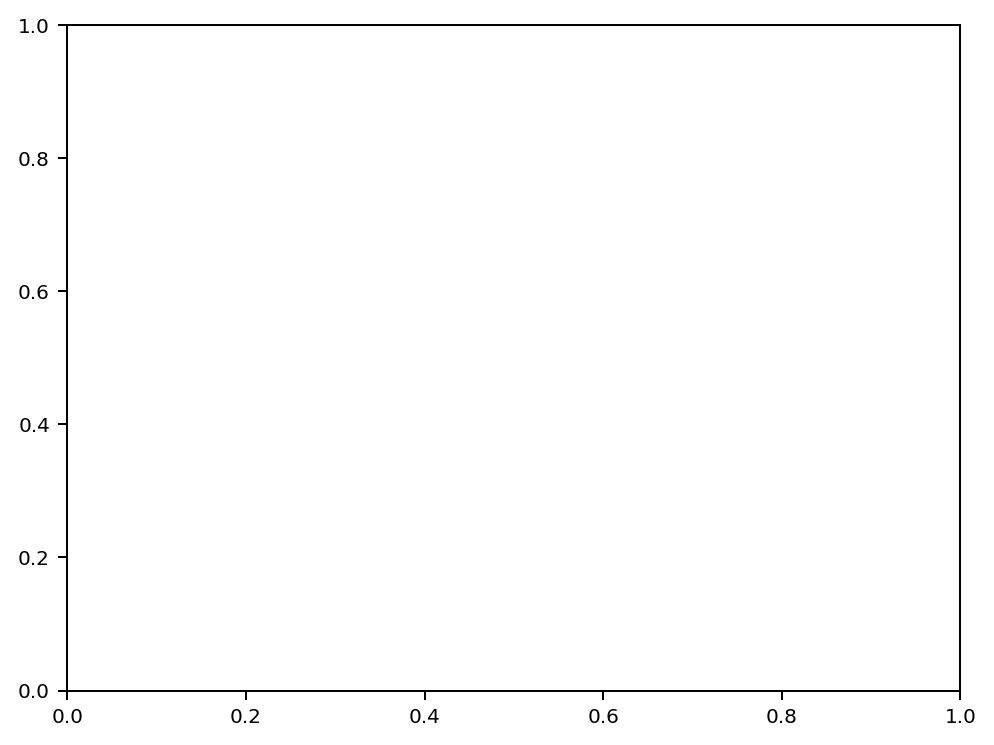

In [58]:
# Define the epoch of interest
epoch = 'spontaneous'

# Sort regions by mean MI
sorted_regions = util.sort_groups(
    df_MI,  # dataframe to sort groups in
    f'{epoch}_MI',  # column with values of interest
    'coarse_region',
    aggfunc=np.mean,
    reference_condition=('control_recording', False)  # region order determined by sorting LSD recording values
)

for condition in [False, True]:
    df_condition = df_MI.query('control_recording == @condition')

    # Loop over regions and ge all MIs
    ## TODO: This is broken, need to find a way to exclude empty regions
    MIs = [df_condition.query('coarse_region == @region')[f'{epoch}_MI'].dropna().values for region in sorted_regions.keys()]
    valid_MIs = np.where([len(mis) > 0 for mis in MIs])
    # cis = [util.bootstrap_median_ci(mi) for mi in sorted_MIs]
    # cis = [np.quantile(mi, [.25, .75]) for mi in sorted_MIs]
    
    # xpos = np.array([sorted_regions[region] for region in MIs.index])
    xpos = np.fromiter(sorted_regions.values(), dtype=int)

    fig, ax = plt.subplots()
    cmap = cmaps['control'] if condition else cmaps['LSD']
    violins = ax.violinplot(MIs[valid_MIs], positions=xpos[valid_MIs], showmedians=False, showextrema=False)
    for violin in violins['bodies']:
        violin.set_facecolor('none')
        violin.set_edgecolor(cmap(1.))
        violin.set_linewidth(1)
        violin.set_alpha(1)
    # for i, (mi, (ci_lower, ci_upper)) in enumerate(zip(sorted_MIs, cis)):
    #     med = np.median(mi)
    #     ax.errorbar(xpos[i], med, yerr=[[med - ci_lower], [ci_upper - med]], fmt='_', color='black')
    ax.axhline(0, ls='--', color='gray')
    for x, units in zip(xpos, MIs):
        ax.text(x - 0.25, 1.05, f'n={len(units)}', fontsize=plots.LABELFONTSIZE, rotation=60)

    ax.set_xticks(np.fromiter(sorted_regions.values(), dtype=int))
    ax.set_xticklabels(sorted_regions.keys())
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('MI')
    ax.set_yticks([-1, 0, 1])
    ax.set_ylim([-1.1, 1.4])
    ax.set_ylabel('Modulation Index')
    ax.set_ylim([-1, 1.5])
    plots.set_plotsize(w=8, h=6)

## Lempel-Ziv Complexity

In [22]:
def cv(series, epoch):
    ts = series['spike_times']
    if len(ts) < 5:
        return np.nan
    ts = ts[(ts > series[f'{epoch}_start']) & (ts < series[f'{epoch}_stop'])]
    isis = np.diff(ts)
    cv = isis.std() / isis.mean()
    return cv

In [32]:
from antropy import lziv_complexity

epochs = [
    'task00_spontaneous',
    'task01_spontaneous',
    'task00_replay',
    'task01_replay'
]

for epoch in epochs:
    df_spikes[f'{epoch}_lzc'] = df_spikes[f'{epoch}_counts'].apply(lambda x: lziv_complexity((x > np.median(x)).astype(int), normalize=True))
    df_spikes[f'{epoch}_cv'] = df_spikes.apply(lambda x: cv(x, epoch), axis='columns')

df_spikes[f'spontaneous_cv'] = df_spikes.apply(lambda x: x[f'task01_spontaneous_cv'] - x[f'task00_spontaneous_cv'], axis='columns')
df_spikes[f'replay_cv'] = df_spikes.apply(lambda x: x[f'task01_replay_cv'] - x[f'task00_replay_cv'], axis='columns')
df_spikes[f'spontaneous_lzcdiff'] = df_spikes.apply(lambda x: x[f'task01_spontaneous_lzc'] - x[f'task00_spontaneous_lzc'], axis='columns')
df_spikes[f'replay_lzcdiff'] = df_spikes.apply(lambda x: x[f'task01_replay_lzc'] - x[f'task00_replay_lzc'], axis='columns')

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1342584/2588200736.py:7: RuntimeWarning: Mean of empty slice.
  cv = isis.std() / isis.mean()
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarnin

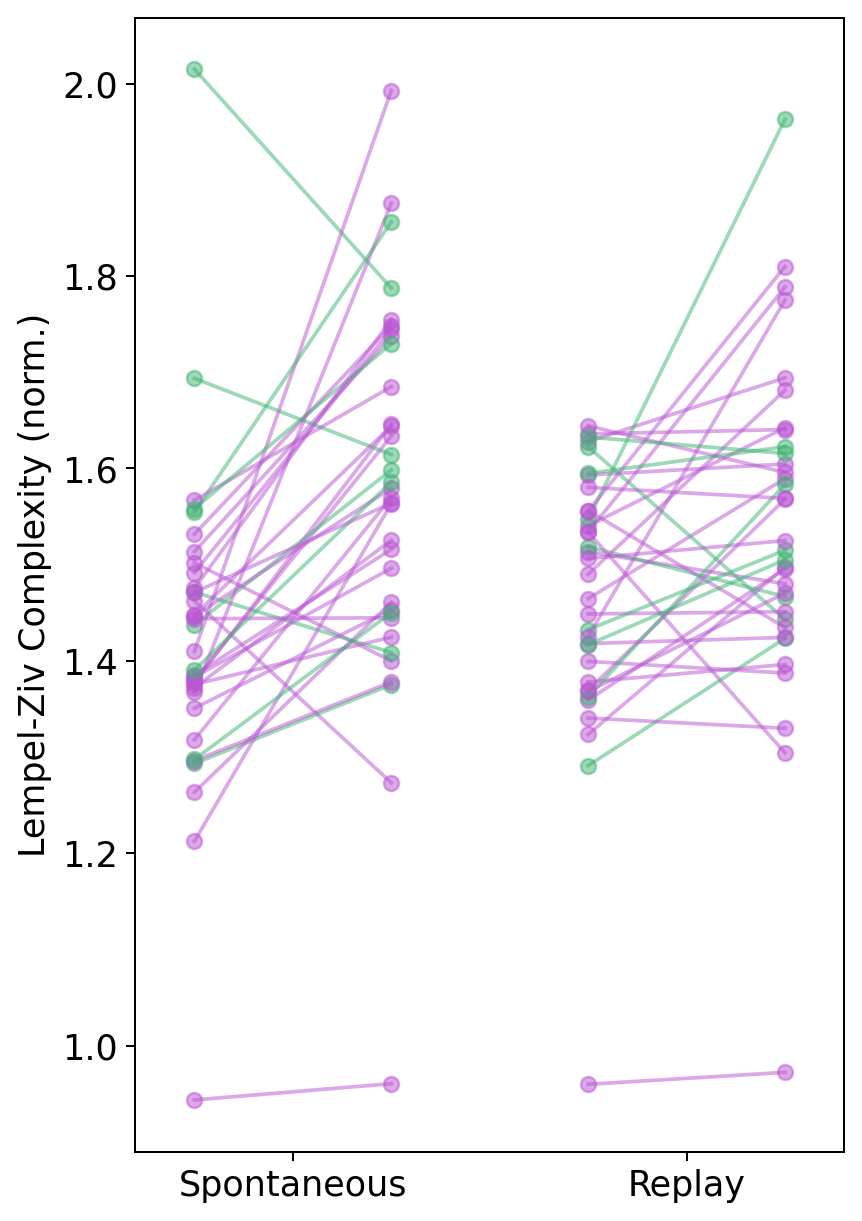

In [33]:
# Plot mean firing rate changes per session (eid)
tasks = ['task00', 'task01']  # here, we split epoch into two separable factors: 1) the task period, pre (00) or post (01) treatment
epochs = ['spontaneous', 'replay',]
metric = 'cv'
xoffset = 0.25
fig, ax = plt.subplots()
for idx, session in df_spikes.groupby('eid'):
    pos = 0
    for epoch in epochs:
        x = pos + np.array([-xoffset, xoffset])
        y = np.array([np.nanmedian(session[f'{task}_{epoch}_{metric}'].replace(-np.inf, np.nan)) for task in tasks])
        color = CONTROLCOLOR if session['control_recording'].unique()[0] else LSDCOLOR
        ax.plot(x, y, color=color, marker='o', alpha=0.5)
        pos += 1
ax.set_xticks(range(len(epochs)))
ax.set_xticklabels([e.capitalize() for e in epochs])
# for xpos, label in zip([-1, 1], ['Pre', 'Post']):
#     ax.text(0 + xpos * xoffset, -0.95, label, va='bottom', ha='center', fontsize=plots.LABELFONTSIZE)
#     ax.text(1 + xpos * xoffset, -0.95, label, va='bottom', ha='center', fontsize=plots.LABELFONTSIZE)
ax.set_xlim([-0.4, 1.4])
# ax.set_yticks([-1, 0, 1])
# ax.set_yticklabels(['$10^{%d}$' % tick for tick in [-1, 0, 1]])
ax.set_ylabel('Lempel-Ziv Complexity (norm.)')

plots.set_plotsize(w=10, h=16, ax=ax)
fig.savefig('figures/lzc.svg')

Amygdala: fitting multi-level model with 1 subjects in both conditions


IndexError: index 1072 is out of bounds for axis 0 with size 1072

> /home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py(1103)<listcomp>()
   1101 
   1102         if array.ndim == 1:
-> 1103             return [np.array(array[self.row_indices[k]])
   1104                     for k in self.group_labels]
   1105         else:



ipdb>  c


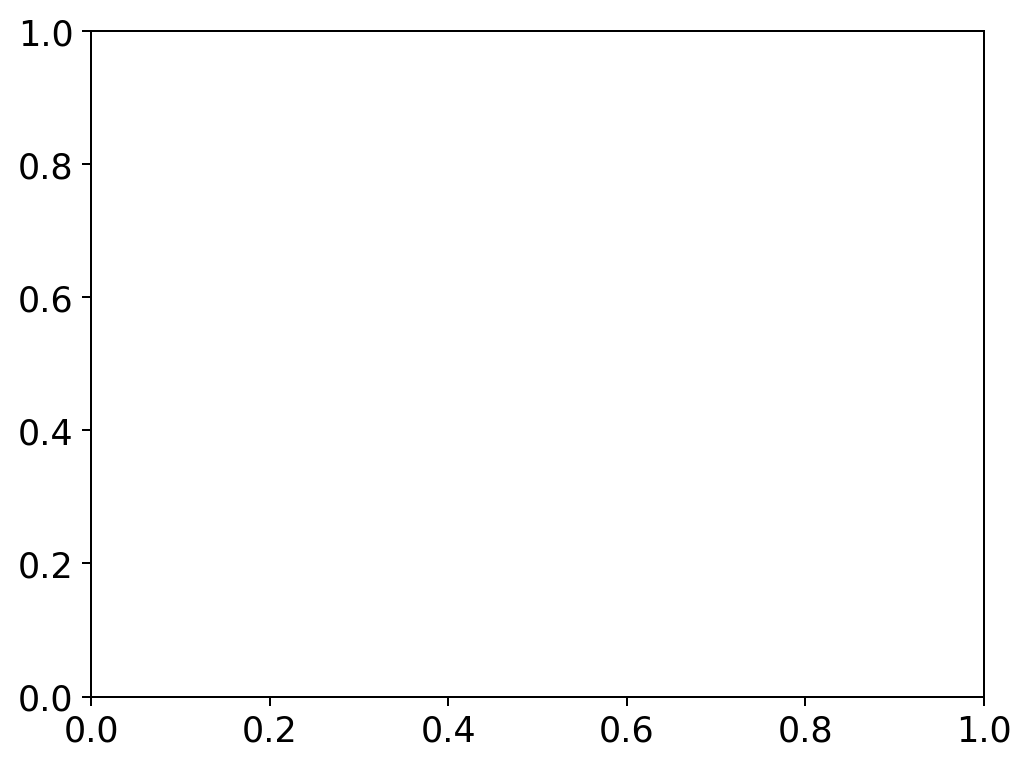

In [34]:
epoch = 'spontaneous'
fig, ax = plt.subplots()

# Compute mean MI per region (all data), for sorting
region_means = df_spikes.groupby('coarse_region')[f'{epoch}_cv'].mean()
sorted_regions = region_means.sort_values(ascending=True).index.tolist()

# Compute means and errors for each group (control and LSD/experimental)
LZC = df_spikes.groupby(['coarse_region', 'control_recording'])[f'{epoch}_cv'].agg(['mean', 'sem']).unstack()

def _statcomp(group_data, min_n_neurons=7):
    group_data.reset_index(drop=True, inplace=True)
    min_neurons_per_condition = min(sum(group_data['control_recording'] == True), sum(group_data['control_recording'] == False))
    n_subjects_both_conditions = sum(group_data.groupby('subject')['control_recording'].nunique() == 2)
    
    if min_neurons_per_condition < min_n_neurons:
        print(f"{group_data.name}: skipping, too few neurons per condition!")
        return np.nan
    elif n_subjects_both_conditions < 1:
        print(f"{group_data.name}: reverting to OLS (ANOVA), too few subjects per condition!")
        model = smf.ols(f'{epoch}_cv ~ C(control_recording)', group_data)
        result = model.fit()
    else:
        print(f"{group_data.name}: fitting multi-level model with {n_subjects_both_conditions} subjects in both conditions")
        model =     model = smf.mixedlm(f'{epoch}_cv ~ C(control_recording)', 
                        data=group_data,
                        groups=group_data['subject'],  # Group by mouse & insertion trajectory
                       ) 
        try:
            result = model.fit(method='lbfgs')
            if not result.converged:
                print(f"Model failed to converge for coarse_region {group_data.name}")
                return np.nan
        except:
            return np.nan
    return result.pvalues['C(control_recording)[T.True]']

pvals = df_spikes.groupby('coarse_region').apply(_statcomp)

ypos = np.arange(len(sorted_regions))

# Plot horizontal bars
for control, offset in zip([False, True], [-0.15, 0.15]):
    means = LZC['mean'].loc[sorted_regions, control].values
    err = LZC['sem'].loc[sorted_regions, control].values * 1.96
    color = CONTROLCOLOR if control else LSDCOLOR
    
    # Set alpha based on whether test was conducted
    alphas = [1.0 if not np.isnan(pvals.loc[region]) else 0.3 for region in sorted_regions]
    
    # Plot each bar individually to set alpha per bar
    for i, (mean, error, alpha) in enumerate(zip(means, err, alphas)):
        ax.barh(ypos[i] + offset, mean, xerr=error, height=0.25, 
                color=color, edgecolor='k', alpha=alpha)

# Vertical reference line
ax.axvline(0, color='k', linewidth=1, linestyle='--')

# Adjust p-values
from statsmodels.stats.multitest import multipletests
pvals_valid = pvals.dropna()  # Only tests that were actually conducted
n_tests = len(pvals_valid)
pvals_adjusted = pvals.copy()
if n_tests > 0:
    _, pvals_corrected, _, _ = multipletests(pvals_valid.values, method='bonferroni')
    pvals_adjusted.loc[pvals_valid.index] = pvals_corrected

for i, region in enumerate(sorted_regions):
    p = pvals_adjusted.loc[region]
    if np.isnan(p) or (p > 0.05): continue
    h_control = LZC['mean'].loc[region, True]
    h_lsd   = LZC['mean'].loc[region, False]
    xpos = np.nanmax([np.abs(h_lsd), np.abs(h_control)]) * np.sign(h_lsd)
    ax.text(0.55, ypos[i], plots.pval2stars(p), ha='left', va='center', fontsize=plots.LABELFONTSIZE, fontweight='bold', color='k', rotation=90)

ax.set_yticks(ypos)
ax.set_yticklabels(sorted_regions)
ax.set_xticks([-0.5, 0, 0.5])
ax.set_xlabel('$\Delta$ Coefficient of Variation (Post - Pre)')

plots.set_plotsize(w=12, h=18)

fig.savefig('figures/CV_regions.svg')

In [35]:
import iblatlas.plots as anatomyplots

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/iblatlas/regions.py:663: RuntimeWarning: All-NaN slice encountered
  all_values = np.nanmedian(v, axis=0)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/iblatlas/regions.py:663: RuntimeWarning: All-NaN slice encountered
  all_values = np.nanmedian(v, axis=0)


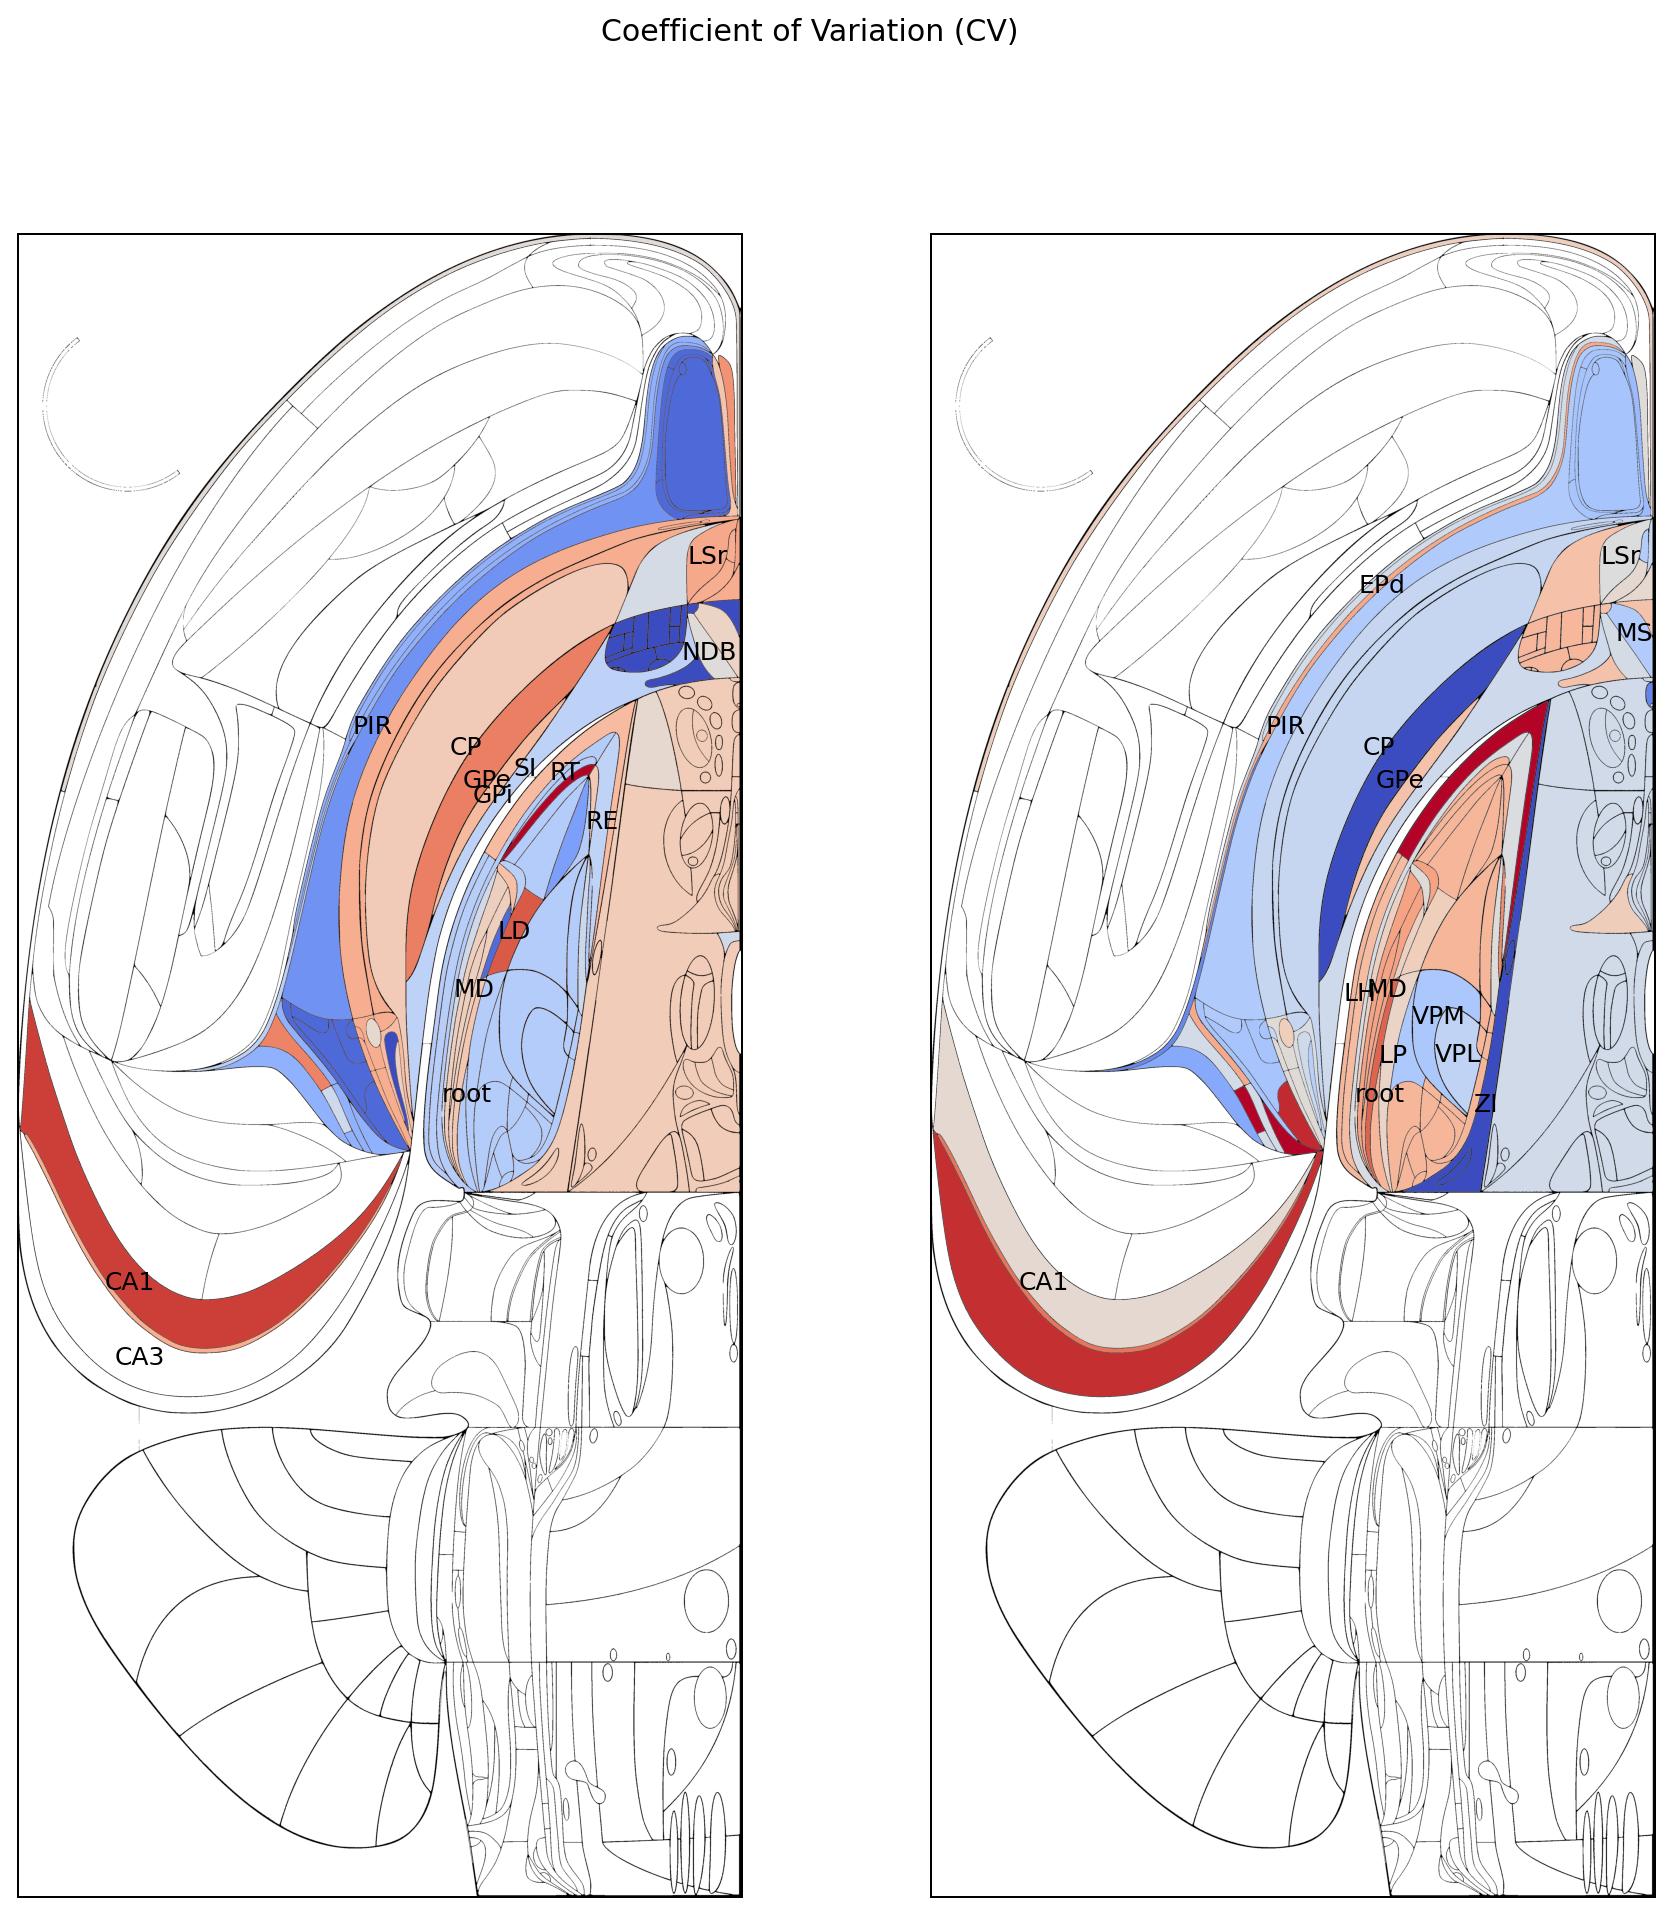

In [36]:
N = 50
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
fig.suptitle('Coefficient of Variation (CV)')

for ax, condition in zip(axs, [True, False]):
    df_condition = df_spikes.query('control_recording == @condition')
    top_groups = (df_condition.groupby('region')['spontaneous_cv']
                  .apply(lambda x: x.abs().max())
                  .nlargest(N))
    ax = anatomyplots.plot_swanson(
        acronyms=df_condition.dropna(subset='region')['region'].values, 
        values=df_condition.dropna(subset='region')['spontaneous_cv'].values,
        ax=ax,
        orientation='portrait',
        empty_color='white',
        cmap='coolwarm',
        vmin=-1,
        vmax=1
    )
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    anatomyplots.annotate_swanson(ax, acronyms=top_groups.index, orientation='portrait')
    # print(top_groups)
fig.savefig('figures/CV_swanson.svg')

In [ ]:
# Plot distribution of units across brain regions
control = True
cmap = cmaps['control'] if control else cmaps['LSD']

## TODO: normalize contribution of units by volume of region
for ap_coord in ap_coords[1::2]:
    fig, axs = plt.subplots(1, 2)
    for ax, control in zip(axs, [False, True]):
        region_counts = df_units.query('control_recording == @control').groupby('region').apply(len).sort_values(ascending=False)
        anatomyplots.plot_scalar_on_slice(
            region_counts.index, 
            np.log10(region_counts.values),
            coord=ap_coord * 1000,  # in um
            background='boundary',
            atlas=AllenAtlas(res_um=50),
            clevels=[0, 4],
            cmap=cmaps['control'] if control else cmaps['LSD'],
            show_cbar=False,
            ax=ax
        )
        ax.text(0.01, 1.02, f'AP: {ap_coord}mm', fontsize=plots.LABELFONTSIZE, transform=ax.transAxes)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    # ax_pos = ax.get_position()  # returns [left, bottom, width, height]
    # cbar_pos = cbar.ax.get_position()
    # cbar.ax.set_position([cbar_pos.x0, ax_pos.y0, cbar_pos.width, ax_pos.height])
    # cbar.set_ticks(np.linspace(0, 4, 5))
    # cbar.set_ticklabels(['$10^{%d}$' % tick for tick in np.linspace(0, 4, 5)])
    # cbar.set_label('N units')

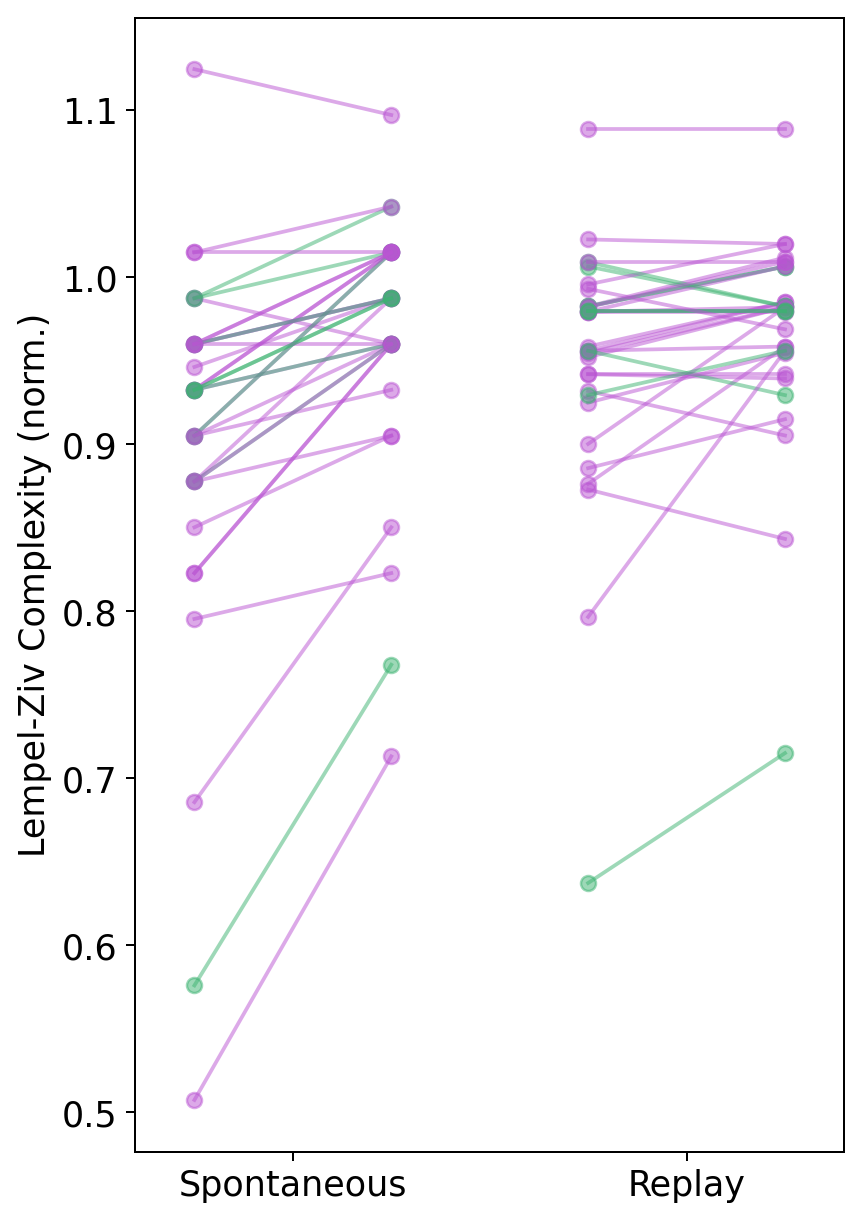

In [101]:
# Plot mean firing rate changes per session (eid)
tasks = ['task00', 'task01']  # here, we split epoch into two separable factors: 1) the task period, pre (00) or post (01) treatment
epochs = ['spontaneous', 'replay',]
metric = 'lzc'
xoffset = 0.25
fig, ax = plt.subplots()
for idx, session in df_spikes.groupby('eid'):
    pos = 0
    for epoch in epochs:
        x = pos + np.array([-xoffset, xoffset])
        y = np.array([np.nanmedian(session[f'{task}_{epoch}_{metric}'].replace(-np.inf, np.nan)) for task in tasks])
        color = CONTROLCOLOR if session['control_recording'].unique()[0] else LSDCOLOR
        ax.plot(x, y, color=color, marker='o', alpha=0.5)
        pos += 1
ax.set_xticks(range(len(epochs)))
ax.set_xticklabels([e.capitalize() for e in epochs])
# for xpos, label in zip([-1, 1], ['Pre', 'Post']):
#     ax.text(0 + xpos * xoffset, -0.95, label, va='bottom', ha='center', fontsize=plots.LABELFONTSIZE)
#     ax.text(1 + xpos * xoffset, -0.95, label, va='bottom', ha='center', fontsize=plots.LABELFONTSIZE)
ax.set_xlim([-0.4, 1.4])
# ax.set_yticks([-1, 0, 1])
# ax.set_yticklabels(['$10^{%d}$' % tick for tick in [-1, 0, 1]])
ax.set_ylabel('Lempel-Ziv Complexity (norm.)')

plots.set_plotsize(w=10, h=16, ax=ax)
fig.savefig('figures/lzc.svg')

Auditory Ctx: skipping, too few neurons per condition!
Entorhinal Ctx: skipping, too few neurons per condition!
Motor Ctx: skipping, too few neurons per condition!
Somatosens. Ctx: skipping, too few neurons per condition!
Visual Ctx: skipping, too few neurons per condition!


/tmp/ipykernel_859790/829822888.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pvals = df_spikes.groupby('coarse_region').apply(_statcomp)


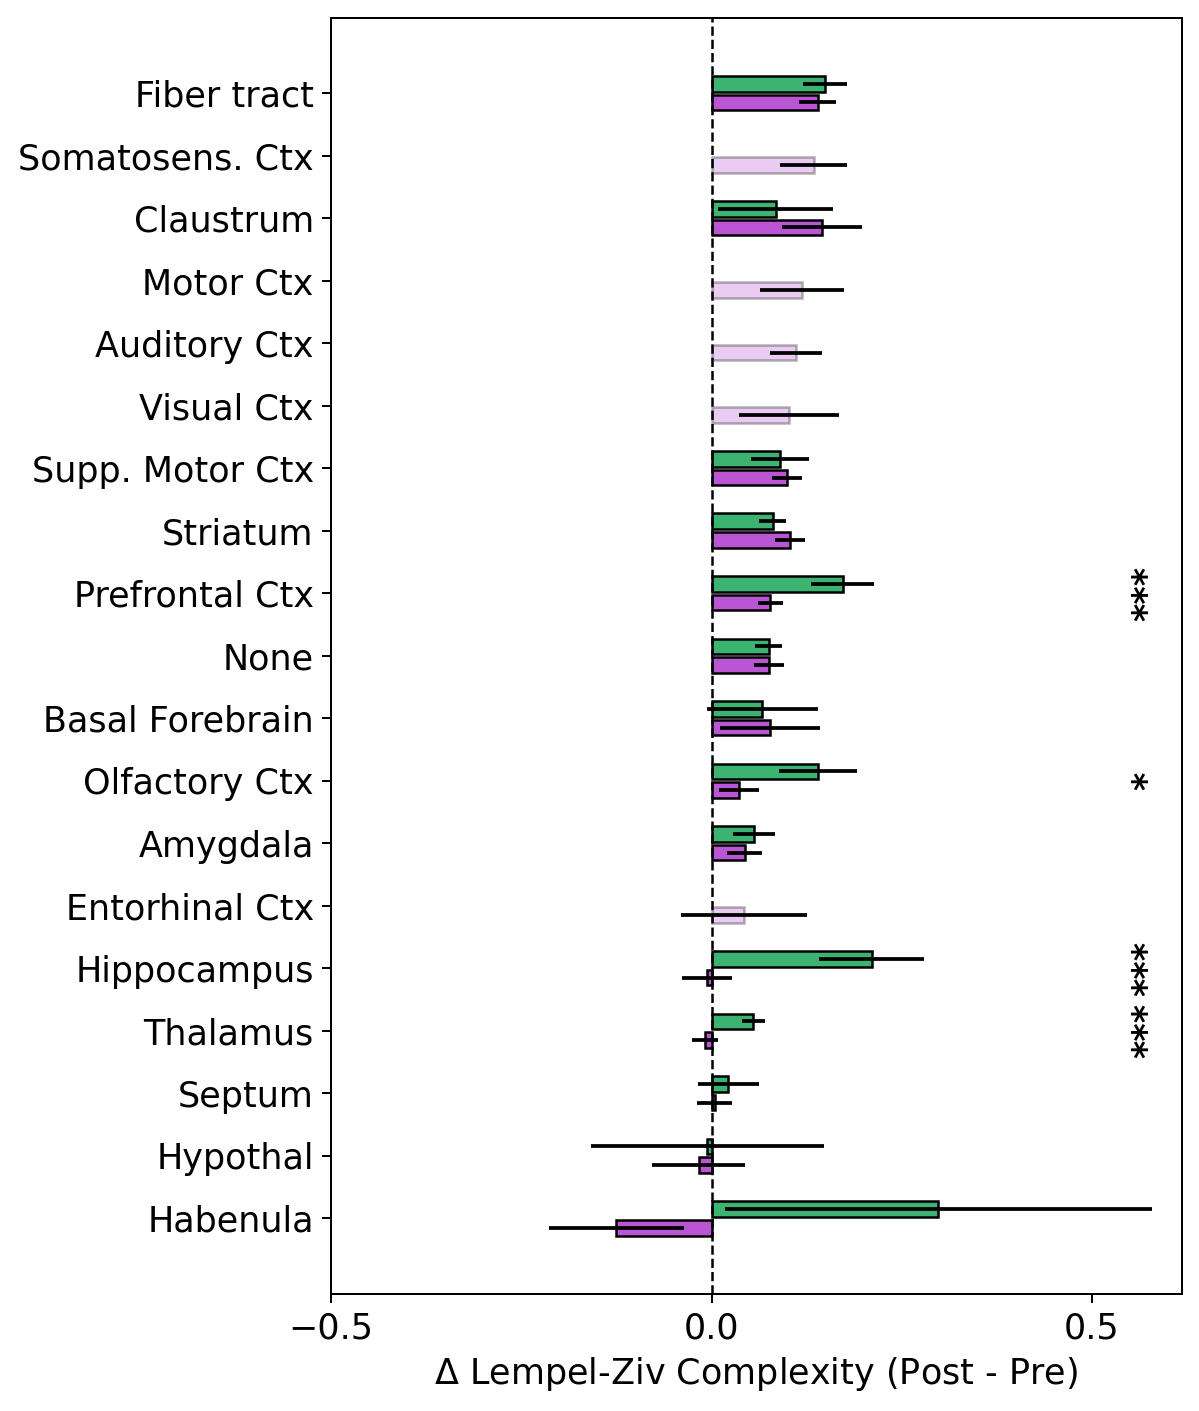

In [129]:
epoch = 'spontaneous'
fig, ax = plt.subplots()

# Compute mean MI per region (all data), for sorting
region_means = df_spikes.groupby('coarse_region')[f'{epoch}_lzcdiff'].mean()
sorted_regions = region_means.sort_values(ascending=True).index.tolist()

# Compute means and errors for each group (control and LSD/experimental)
LZC = df_spikes.groupby(['coarse_region', 'control_recording'])[f'{epoch}_lzcdiff'].agg(['mean', 'sem']).unstack()

def _statcomp(group_data, min_n_neurons=7):
    group_data.reset_index(drop=True, inplace=True)
    min_neurons_per_condition = min(sum(group_data['control_recording'] == True), sum(group_data['control_recording'] == False))
    
    if min_neurons_per_condition < min_n_neurons:
        print(f"{group_data.name}: skipping, too few neurons per condition!")
        return np.nan
    else:
        model = smf.ols(f'{epoch}_lzcdiff ~ C(control_recording)', group_data)
        result = model.fit()
    return result.pvalues['C(control_recording)[T.True]']

pvals = df_spikes.groupby('coarse_region').apply(_statcomp)

ypos = np.arange(len(sorted_regions))

# Plot horizontal bars
for control, offset in zip([False, True], [-0.15, 0.15]):
    means = LZC['mean'].loc[sorted_regions, control].values
    err = LZC['sem'].loc[sorted_regions, control].values * 1.96
    color = CONTROLCOLOR if control else LSDCOLOR
    
    # Set alpha based on whether test was conducted
    alphas = [1.0 if not np.isnan(pvals.loc[region]) else 0.3 for region in sorted_regions]
    
    # Plot each bar individually to set alpha per bar
    for i, (mean, error, alpha) in enumerate(zip(means, err, alphas)):
        ax.barh(ypos[i] + offset, mean, xerr=error, height=0.25, 
                color=color, edgecolor='k', alpha=alpha)

# Vertical reference line
ax.axvline(0, color='k', linewidth=1, linestyle='--')

# Adjust p-values
from statsmodels.stats.multitest import multipletests
pvals_valid = pvals.dropna()  # Only tests that were actually conducted
n_tests = len(pvals_valid)
pvals_adjusted = pvals.copy()
if n_tests > 0:
    _, pvals_corrected, _, _ = multipletests(pvals_valid.values, method='bonferroni')
    pvals_adjusted.loc[pvals_valid.index] = pvals_corrected

for i, region in enumerate(sorted_regions):
    p = pvals_adjusted.loc[region]
    if np.isnan(p) or (p > 0.05): continue
    h_control = LZC['mean'].loc[region, True]
    h_lsd   = LZC['mean'].loc[region, False]
    xpos = np.nanmax([np.abs(h_lsd), np.abs(h_control)]) * np.sign(h_lsd)
    ax.text(0.55, ypos[i], plots.pval2stars(p), ha='left', va='center', fontsize=plots.LABELFONTSIZE, fontweight='bold', color='k', rotation=90)

ax.set_yticks(ypos)
ax.set_yticklabels(sorted_regions)
ax.set_xticks([-0.5, 0, 0.5])
ax.set_xlabel('$\Delta$ Lempel-Ziv Complexity (Post - Pre)')

plots.set_plotsize(w=12, h=18)

fig.savefig('figures/LZC_regions.svg')

### Changepoint detection

In [5]:
df_spikes['LSD_start'] = df_spikes['LSD_admin'] - 5 * 60
df_spikes['LSD_stop'] = df_spikes['LSD_admin'] + 30 * 60

dt = 1
df_spikes[f'LSD_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch='LSD', dt=dt, axis='columns')
df_spikes[f'LSD_rate'] = df_spikes[f'LSD_counts'].apply(lambda x: (x / dt).mean())

100%|███████████████████████████████████| 14886/14886 [00:05<00:00, 2773.85it/s]


In [9]:
import ruptures as rpt

def binseg(y):
    return rpt.Binseg().fit(y).predict(n_bkps=1)

df_spikes['bkpts'] = df_spikes['LSD_counts'].progress_apply(binseg)

100%|█████████████████████████████████████| 14886/14886 [12:47<00:00, 19.41it/s]


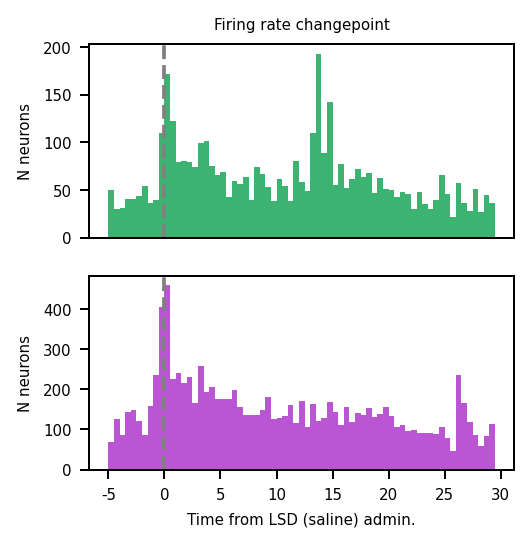

In [38]:
fig, axs = plt.subplots(2)

df = df_spikes.query('control_recording == True')
axs[0].hist(df['bkpts'].apply(lambda x: x[0]), bins=np.arange(0, 35 * 60, 30), color=CONTROLCOLOR)
axs[0].axvline(5 * 60, ls='--', color='gray')
df = df_spikes.query('control_recording == False')
axs[1].hist(df['bkpts'].apply(lambda x: x[0]), bins=np.arange(0, 35 * 60, 30), color=LSDCOLOR)
axs[1].axvline(5 * 60, ls='--', color='gray')

axs[0].set_title('Firing rate changepoint')
axs[0].set_xticks([])
axs[1].set_xticks(np.arange(0, 40 * 60, 300))
axs[1].set_xticklabels(np.arange(0, 40, 5, dtype=int) - 5)
axs[1].set_xlabel('Time from LSD (saline) admin.')
axs[0].set_ylabel('N neurons')
axs[1].set_ylabel('N neurons')

plots.set_plotsize(w=6)